# Configurations

### Import

In [1]:
import os
import joblib

from IPython.display import clear_output
import random
import numpy as np
import pandas as pd; pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from statsmodels.tsa.seasonal import seasonal_decompose

from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset

import pytorch_forecasting as pf

import torch
from PIL import Image
import torchvision
from torchvision import transforms
from transformers import SwinModel

/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Read

In [2]:
# Read transaction
df_trans = pd.read_csv("../HnM/transactions_train.csv", parse_dates=["t_dat"], dtype={"article_id":str})
df_trans["year"] = df_trans["t_dat"].dt.year.astype(str)
df_trans["month"] = df_trans["t_dat"].dt.month.astype(str)
df_trans["t_dat"] = df_trans["year"] + "-" + df_trans["month"] + "-" + "1"
df_trans["t_dat"] = pd.to_datetime(df_trans["t_dat"])

df_trans = df_trans.groupby(["article_id", "t_dat"], as_index=False).agg(sales=("customer_id","size"), price=("price","mean"))
df_trans["day_cnt"] = df_trans.groupby(["article_id"])["t_dat"].transform("size")
df_trans = df_trans.sort_values(["day_cnt", "sales"], ascending=False).reset_index(drop=True)

# Read article info
df_article = pd.read_csv("../HnM/articles.csv", dtype={"article_id":str})
df_article = df_article[["article_id"] + [col for col in df_article.columns if "name" in col]]

In [3]:
# Merge two datasets
df_raw = pd.merge(df_trans, df_article, on="article_id")
df_raw.head(3)

,article_id,t_dat,sales,price,day_cnt,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name
0,0610776002,2020-04-01,3587,0.007954,25,Tilly (1),T-shirt,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
1,0610776002,2020-05-01,2168,0.008227,25,Tilly (1),T-shirt,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic
2,0610776002,2019-06-01,1951,0.008219,25,Tilly (1),T-shirt,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic


# Dataset

### Params

In [4]:
n_smaples = 99999999999999 # Sampling
# n_smaples = 100 # Sampling
random_state = 0
batch_size = 128

# d_model = 256
# nhead = 8
# d_ff = 512
# dropout = 0.3
# num_layers = 6

d_model = 128
nhead = 4
d_ff = 256
dropout = 0.3
num_layers = 4

# Seed set
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)

### Preprocess

In [5]:
df_prep = df_raw.copy()

# Sampling
samples = df_raw["article_id"].unique()
df_prep = df_prep[df_prep["article_id"].isin(samples[:n_smaples])]
print(df_prep.shape)

# Expand_date
def func(x):
    # date_ref = pd.DataFrame(pd.date_range(x["t_dat"].min(), x["t_dat"].max(), freq="MS"), columns=["t_dat"])
    # # date_ref = pd.DataFrame(pd.date_range(x["t_dat"].min(), x["t_dat"].max(), freq="d"), columns=["t_dat"])
    # x = pd.merge(x, date_ref, on="t_dat", how="right")

    # # Cope with special columns
    # x["sales"] = x["sales"].fillna(0)
    # x["price"] = x["price"].fillna(method="ffill")

    # # Cope with static columns
    # target_cols = [i for i in x.columns if i not in ["t_dat", "sales", "price"]]
    # fill_values = x[target_cols].iloc[0].values
    # x[target_cols] = fill_values

    # Scaling
    scaler = MinMaxScaler()
    x["sales"] = scaler.fit_transform(x[["sales"]]) + 1
    return x

df_prep = df_prep.groupby("article_id").apply(func).reset_index(drop=True)
df_prep = df_prep.sort_values(["article_id", "t_dat"])
print(df_prep.shape)

# Encode imgpath
encoder = LabelEncoder()
df_prep["img_path"] = df_prep["article_id"].apply(lambda x: f'../HnM/images/{x[:3]}/{x}.jpg') # Generate image path
df_prep["is_valid"] = df_prep["img_path"].apply(lambda x: 1 if os.path.isfile(x) else 0) # Check whether the article has corresponding image file
df_prep = df_prep[df_prep["is_valid"] == 1] # Valid if having corresponding image

df_prep["img_path"] = encoder.fit_transform(df_prep["img_path"])

# Make time_idx
df_prep["time_idx"] = df_prep.groupby("article_id").cumcount()
print(df_prep.shape)
df_prep.head(3)

(768883, 17)
(768883, 17)
(765572, 20)


,article_id,t_dat,sales,price,day_cnt,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,img_path,is_valid,time_idx
7,0108775015,2018-09-01,1.398433,0.008026,22,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0,1,0
1,0108775015,2018-10-01,1.922845,0.008081,22,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0,1,1
0,0108775015,2018-11-01,2.000000,0.007889,22,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,0,1,2


In [6]:
df_prep.to_parquet("df_prep.parquet")
joblib.dump(encoder, "encoder.pkl")

['encoder.pkl']

### Dataset

In [7]:
df_prep = pd.read_parquet("df_prep.parquet")
encoder = joblib.load("encoder.pkl")

In [8]:
encoder_max_len = 24
pred_len = 6

cutoff = df_prep["time_idx"].max() - pred_len; print(cutoff)

train_dataset = pf.TimeSeriesDataSet(
    df_prep[df_prep["time_idx"] <= cutoff],
    time_idx = "time_idx",
    target = "sales",
    group_ids = ["article_id"],
    
    min_encoder_length = encoder_max_len//2,
    max_encoder_length = encoder_max_len,
    min_prediction_length = pred_len,
    max_prediction_length = pred_len,

    time_varying_unknown_reals = ["sales", "img_path"],
    # time_varying_unknown_reals = ["sales"],
    target_normalizer = None,
    scalers = {"img_path":None}
)
valid_dataset = pf.TimeSeriesDataSet.from_dataset(train_dataset, df_prep, predict=True, stop_randomization=True)

train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, shuffle=True, num_workers=16)
valid_dataloader = valid_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=16)
print(len(train_dataloader)); print(len(valid_dataloader))

18


/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1281: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 98704 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__article_id': '0108775051'}, {'__group_id__article_id': '0111565003'}, {'__group_id__article_id': '0112679048'}, {'__group_id__article_id': '0112679052'}, {'__group_id__article_id': '0114428026'}, {'__group_id__article_id': '0114428030'}, {'__group_id__article_id': '0116379047'}, {'__group_id__article_id': '0118458003'}, {'__group_id__article_id': '0118458004'}, {'__group_id__article_id': '0118458028'}]
  warnings.warn(


109
43


/home/sh-sungho.park/anaconda3/envs/cudatest/lib/python3.8/site-packages/pytorch_forecasting/data/timeseries.py:1281: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 98704 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__article_id': '0108775051'}, {'__group_id__article_id': '0111565003'}, {'__group_id__article_id': '0112679048'}, {'__group_id__article_id': '0112679052'}, {'__group_id__article_id': '0114428026'}, {'__group_id__article_id': '0114428030'}, {'__group_id__article_id': '0116379047'}, {'__group_id__article_id': '0118458003'}, {'__group_id__article_id': '0118458004'}, {'__group_id__article_id': '0118458028'}]
  warnings.warn(


# Model

### Architecture

In [9]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, max_len, d_model, dropout):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)

        position = torch.arange(max_len).reshape(-1,1).to(device)
        i = torch.arange(d_model).to(device)//2
        exp_term = 2*i/d_model
        div_term = torch.pow(10000, exp_term).reshape(1, -1)
        self.pos_encoded = position / div_term

        self.pos_encoded[:, 0::2] = torch.sin(self.pos_encoded[:, 0::2])
        self.pos_encoded[:, 1::2] = torch.cos(self.pos_encoded[:, 1::2])

    def forward(self, x):
        output = x + self.pos_encoded[:x.shape[1], :]
        return self.dropout(output)

class Mask(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def get_padding_mask(self, arr):
        res = torch.eq(arr, 0).type(torch.FloatTensor).to(device)
        res = torch.where(res==1, -torch.inf, 0)
        return res
    
    def get_lookahead_mask(self, arr):
        seq_len = arr.shape[1]
        mask = torch.triu(torch.ones((seq_len, seq_len))*-torch.inf, 1).to(device)
        return mask

    def forward(self, arr):
        padding_mask = self.get_padding_mask(arr)
        lookahead_mask = self.get_lookahead_mask(arr)
        return padding_mask, lookahead_mask

class Transformer(torch.nn.Module):
    def __init__(self, d_model, max_seq_len, nhead, num_layers, d_ff=512, dropout=0.3):
        super().__init__()
        self.enc_mask = Mask()
        self.enc_embedding = torch.nn.Linear(1, d_model)
        self.elu1 = torch.nn.ELU()
        self.enc_pos_encoding = PositionalEncoding(max_seq_len, d_model, dropout)
        self.encoder = torch.nn.TransformerEncoder(torch.nn.TransformerEncoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)

        self.dec_mask = Mask()
        self.swin_transformer = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224") # Get pre-trained SwinTransformer
        self.elu2 = torch.nn.ELU()
        self.dec_embedding = torch.nn.Linear(self.swin_transformer.config.hidden_size, d_model)
        self.elu3 = torch.nn.ELU()
        self.dec_pos_encoding = PositionalEncoding(max_seq_len, d_model, dropout)
        self.decoder = torch.nn.TransformerDecoder(torch.nn.TransformerDecoderLayer(d_model, nhead, d_ff, dropout, batch_first=True), num_layers)
        
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(d_model*49, d_model)
        self.elu4 = torch.nn.ELU()
        self.linear2 = torch.nn.Linear(d_model, pred_len)
        self.elu5 = torch.nn.ELU()
        
    def forward(self, enc_input, img):
        enc_padding_mask, _ = self.enc_mask(enc_input.squeeze())
        enc_output = self.elu1(self.enc_embedding(enc_input))
        enc_output = self.enc_pos_encoding(enc_output)
        
        enc_output = self.encoder(enc_output, src_key_padding_mask=enc_padding_mask)

        # dec_padding_mask, dec_lookahead_mask = self.dec_mask(dec_input.squeeze())
        dec_swin = self.elu2(self.swin_transformer(img).last_hidden_state)
        dec_output = self.elu3(self.dec_embedding(dec_swin))
        # dec_output = self.dec_pos_encoding(dec_output)

        dec_output = self.decoder(tgt=dec_output, memory=enc_output)

        output = self.elu4(self.linear1(self.flatten(dec_output)))
        output = self.linear2(output)

        return output

device = torch.device("cuda")
model = Transformer(d_model, encoder_max_len, nhead, num_layers, d_ff, dropout)
model.to(device)
""

''

### Train

In [10]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]) # Transform image based on ImageNet standard

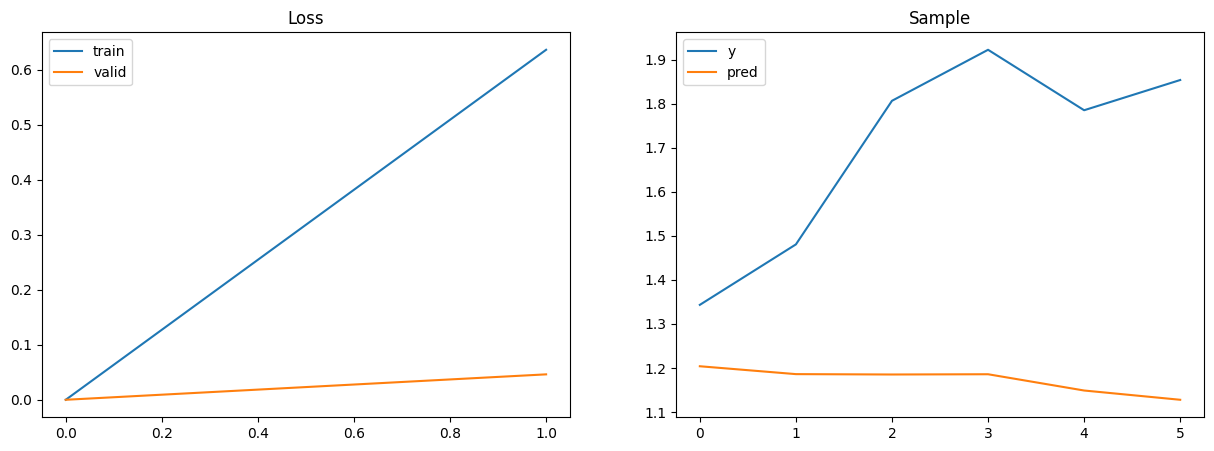

 1:55/109 mean_train_loss: 0.053744455599891286 -- mean_val_loss: 0.046207208186388016

KeyboardInterrupt: 

: 

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# loss_fn = pf.metrics.quantile.QuantileLoss()
loss_fn = torch.nn.MSELoss()
# temp = None
# def loss_fn(pred, y):
#     mask = y.greater(0).type(torch.float)
#     pred *= mask

#     fn = torch.nn.MSELoss()
#     return fn(pred, y)

def plot_sample(y, pred):
    # Plot sample
    clear_output(wait=True)
    y_sample = y[-1]
    pred_sample = pred[-1].detach().cpu()
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(train_loss_li, label="train")
    plt.plot(val_loss_li, label="valid")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(y_sample, label="y")
    plt.plot(pred_sample, label="pred")
    plt.title("Sample")
    plt.legend()
    plt.show()

def img_transform(img_path):
    img_path = encoder.inverse_transform(img_path.type(torch.int))
    img_li = []
    for path in img_path:
        img = transform(Image.open(path).convert("RGB"))
        img_li.append(img)
    return torch.stack(img_li, dim=0)

def train(epoch, val_loss, train_loss_li, val_loss_li):
    model.train()
    total_len = len(train_dataloader)
    total_loss = 0
    for n, data in enumerate(train_dataloader):
        x, y = data
        sales = x["encoder_cont"][:, :, 1].unsqueeze(-1)
        img = img_transform(x["encoder_cont"][:, :, 2][:, 0])
        y = y[0]
        
        # Train
        optimizer.zero_grad()
        pred = model(sales.to(device), img.to(device)).squeeze()

        # plot sample
        if n % 10 == 0: plot_sample(y, pred)
        loss = loss_fn(pred, y.to(device))
        loss.backward()
        optimizer.step()

        # Report
        total_loss += loss.item()
        mean_loss = total_loss / (n+1)
        print(f"\r {epoch}:{n}/{total_len} mean_train_loss: {mean_loss} -- mean_val_loss: {val_loss}", end="")

    print()
    return mean_loss

def val(epoch):
    model.eval()
    total_len = len(valid_dataloader)
    total_loss = 0
    for n, data in enumerate(valid_dataloader):
        x, y = data
        sales = x["encoder_cont"][:, :, 1].unsqueeze(-1)
        img = img_transform(x["encoder_cont"][:, :, 2][:, 0])
        y = y[0]
        
        # Pred
        with torch.no_grad():
            pred = model(sales.to(device), img.to(device)).squeeze()
            loss = loss_fn(pred, y.to(device))

            # Report
            total_loss += loss.item()
            mean_loss = total_loss / (n+1)
            print(f"\r {epoch}:{n}/{total_len} mean_val_loss: {mean_loss}", end="")

    print()
    return mean_loss
 
def plot_loss(train_loss_li, val_loss_li):
    # Plot loss
    clear_output(wait=True)
    plt.plot(train_loss_li, label="train")
    plt.plot(val_loss_li, label="valid")
    plt.legend()
    plt.show()   

epoch = 15
train_loss_li, val_loss_li = [0], [0]
val_loss = 0

for e in range(epoch):
    train_loss = train(e, val_loss, train_loss_li, val_loss_li) # Train
    val_loss = val(e)

    train_loss_li.append(train_loss)
    val_loss_li.append(val_loss)
    # plot_loss(train_loss_li, val_loss_li)